## Setup

In [39]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import imghdr
import numpy as np

In [40]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [41]:
tf.config.list_physical_devices('GPU')

[]

## Remove dodgy images

In [9]:
data_dir = 'data'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [10]:
os.listdir(data_dir)

['Caries', 'Healthy Teeth']

In [42]:
img = cv2.imread(os.path.join('data', 'Caries', '1.jpg'))
type(img), img.shape

(numpy.ndarray, (799, 1473, 3))

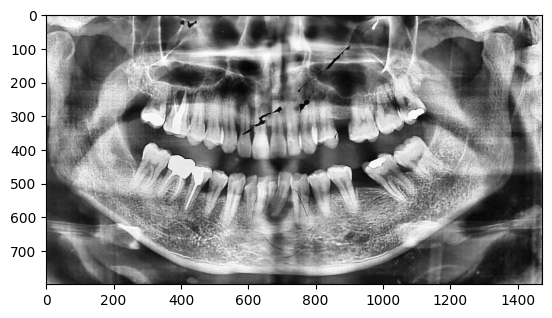

In [44]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [25]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

## Load data

In [90]:
data = tf.keras.utils.image_dataset_from_directory('data', image_size=(256, 256))

Found 342 files belonging to 2 classes.


In [91]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

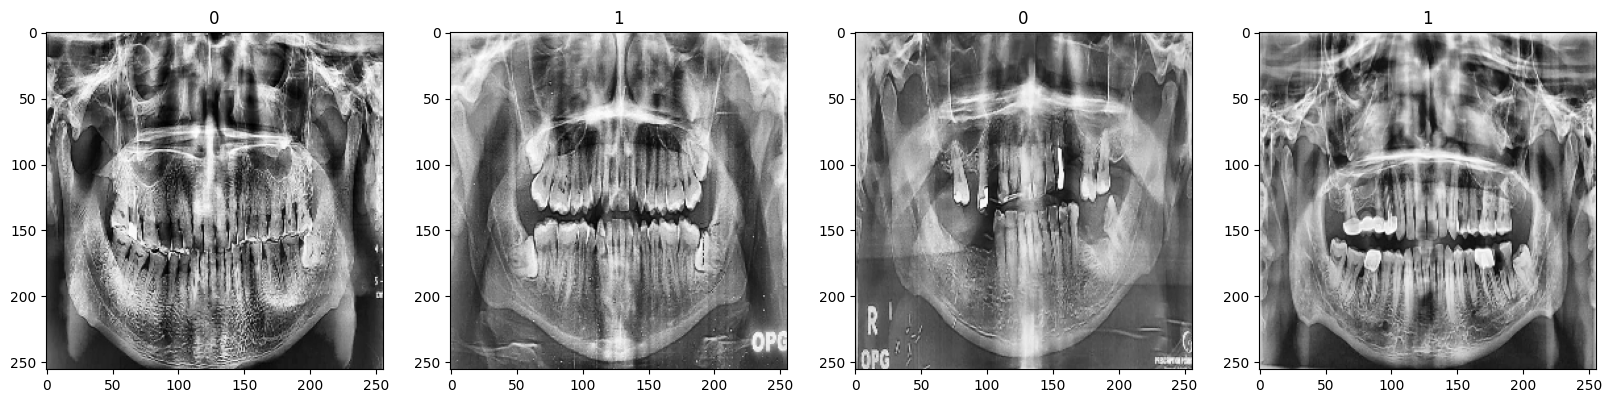

In [92]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Scale data

In [93]:
data = data.map(lambda x,y: (x/255, y))
# data.as_numpy_iterator().next()

## Split data

In [94]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [95]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Build deep learning model

In [102]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import layers

In [100]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1)
])

In [97]:
model = Sequential()

In [ ]:
model.add(data_augmentation)
model.add(layers.Rescaling(1./255))

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

c:\Dental Image Classification\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [105]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [106]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [107]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [108]:
from sklearn.utils.class_weight import compute_class_weight

labels = []
for img, label in data:
    labels.extend(label.numpy())

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(class_weights))
print(class_weights)


{0: np.float64(1.4369747899159664), 1: np.float64(0.7668161434977578)}


In [109]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback], class_weight=class_weights)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 557ms/step - accuracy: 0.5112 - loss: 0.7807 - val_accuracy: 0.2969 - val_loss: 0.7257
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 568ms/step - accuracy: 0.4118 - loss: 0.6962 - val_accuracy: 0.5938 - val_loss: 0.6880
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 539ms/step - accuracy: 0.6673 - loss: 0.6658 - val_accuracy: 0.5938 - val_loss: 0.6799
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 528ms/step - accuracy: 0.6307 - loss: 0.6847 - val_accuracy: 0.7031 - val_loss: 0.6821
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 508ms/step - accuracy: 0.5560 - loss: 0.6860 - val_accuracy: 0.6406 - val_loss: 0.6568
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 519ms/step - accuracy: 0.6601 - loss: 0.6494 - val_accuracy: 0.6406 - val_loss: 0.6751
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 548ms/step - accuracy: 0.6031 - loss: 0.6878 - val_accuracy: 0.5469 - val_loss: 0.6929
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 561ms/step - accuracy: 0.5962 - loss: 0.6672 - val_accuracy: 0.6250 - val_loss:

## Plot Performance

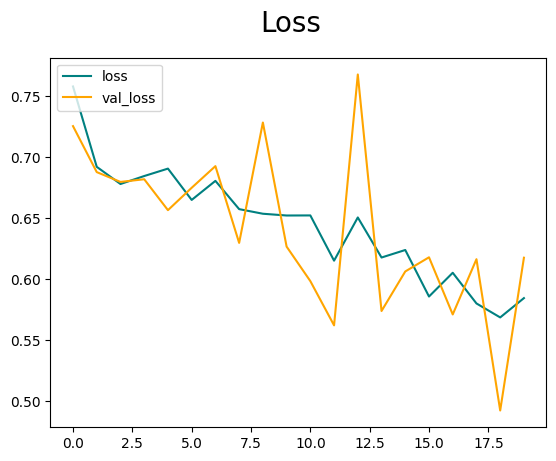

In [110]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

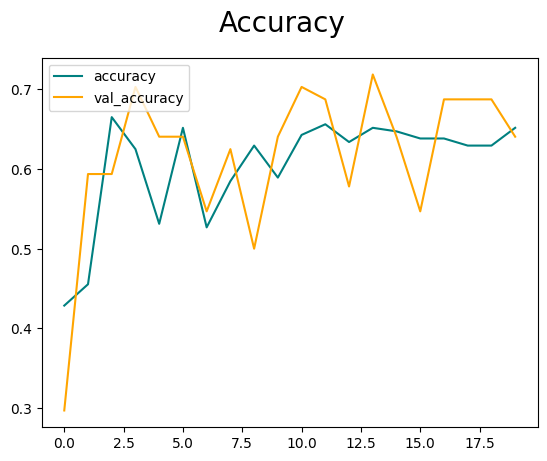

In [111]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Evaluate

In [112]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [113]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [114]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


In [115]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.9166667, shape=(), dtype=float32) tf.Tensor(0.55, shape=(), dtype=float32) tf.Tensor(0.6875, shape=(), dtype=float32)


In [116]:
acc = BinaryAccuracy()

for images, labels in test:
    preds = model(images, training=False)
    acc.update_state(labels, preds)

print("Test Accuracy:", acc.result().numpy())

Test Accuracy: 0.71875


## Test

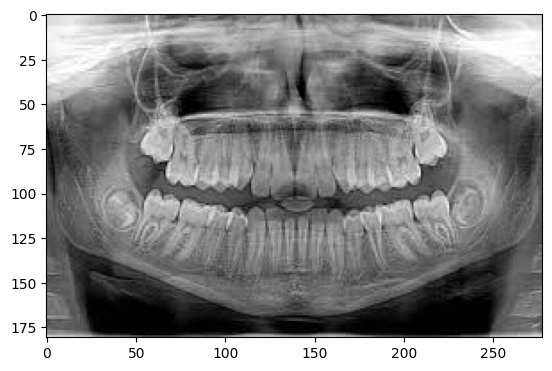

In [117]:
img = cv2.imread('healthytest.jpg')
plt.imshow(img)
plt.show()

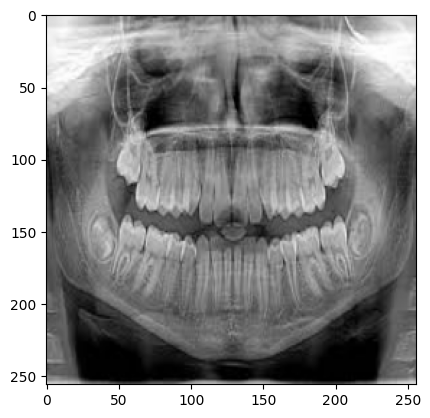

In [118]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [119]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


In [120]:
if yhat > 0.5: 
    print(f'Predicted tooth is healthy.')
else:
    print(f'Predicted tooth is caries.')

Predicted tooth is healthy.


## Save the model

In [121]:
from tensorflow.keras.models import load_model

In [122]:
model.save(os.path.join('models', 'dentalclassificationmodel.keras'))

In [88]:
print(os.getcwd())

c:\Dental Image Classification


In [123]:
model = load_model('models/dentalclassificationmodel.keras')
model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


array([[0.6407601]], dtype=float32)